In [286]:
# ensure latest module is used
from importlib import reload
import project_functions
reload(project_functions)

# import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from project_functions import huber_loss, huber_loss_coordinates, get_first_lap, plot_traj_reward, plot_misalignment, interpolate_trajectories, print_huber_losses

# PD Control Training Data

In [287]:
foldername = "test_data"

# get pd data
filepath_pd = os.path.join(foldername, 'test_pd_data.csv')
df_pd = pd.read_csv(filepath_pd)

x_pd = df_pd['cur_pos_x'].values
y_pd = df_pd['cur_pos_z'].values
ytrue = df_pd['steering_angle']

x_pd_first_lap, y_pd_first_lap = get_first_lap(x_pd, y_pd, 0.7, 0.005)

# get ground truth data
filepath_gt = os.path.join(foldername, 'gt_udem1.csv')
df_gt = pd.read_csv(filepath_gt)

x_gt = df_gt['bez_x'].values
y_gt = df_gt['bez_z'].values

x_gt_first_lap, y_gt_first_lap = get_first_lap(x_gt, y_gt, 0.03, 0.03)

## Raw Data - Unweighted

Model Test Huber Loss: 0.10230555438079605
PD and Model Huber Loss: 0.04218866894798993
Ground Truth and Model Huber Loss: 0.031254925610566676


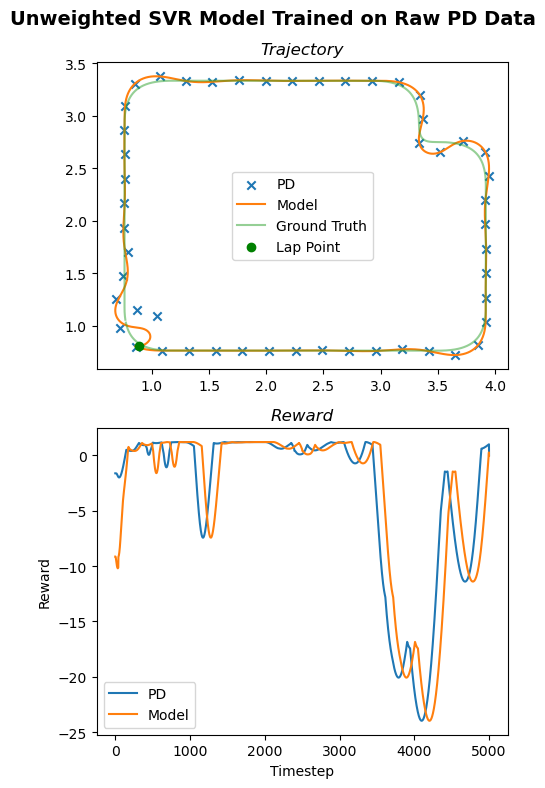

/Users/sophiachiang/Documents/ELEN90088/elen90088_final/project/project_functions.py:156: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


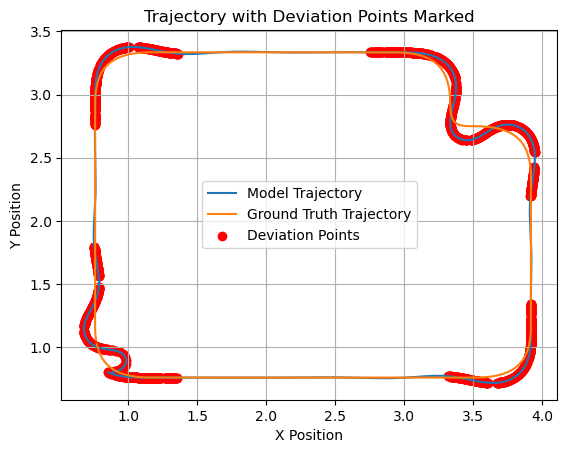

Time Spent Misaligned: 2269


In [289]:
model_name = "unweighted_svr_model_raw_pd"

# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_first_lap, y_model_first_lap = get_first_lap(x_model, y_model, 0.7, 0.005)

# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_first_lap, y_gt_first_lap, x_pd_first_lap, y_pd_first_lap, x_model_first_lap, y_model_first_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_first_lap, y_model_first_lap)

plot_traj_reward(x_pd, y_pd, x_model_first_lap, y_model_first_lap, x_gt_first_lap, y_gt_first_lap, df_model, df_pd, "Unweighted SVR Model Trained on Raw PD Data")
plot_misalignment(x_model_first_lap, y_model_first_lap, x_gt_first_lap, y_gt_first_lap, max_angle_deviation=5)

## Raw Data - Weighted

In [275]:
model_name = "weighted_svr_model_raw_pd"

In [276]:
# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values

In [277]:
x_model_first_lap, y_model_first_lap = get_first_lap(x_model, y_model, 0.7, 0.005)

In [278]:
# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_first_lap, y_gt_first_lap, x_pd_first_lap, y_pd_first_lap, x_model_first_lap, y_model_first_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_first_lap, y_model_first_lap)

Model Test Huber Loss: 0.04494061799599221
PD and Model Huber Loss: 0.0029425921678399715
Ground Truth and Model Huber Loss: 0.004508974046404208


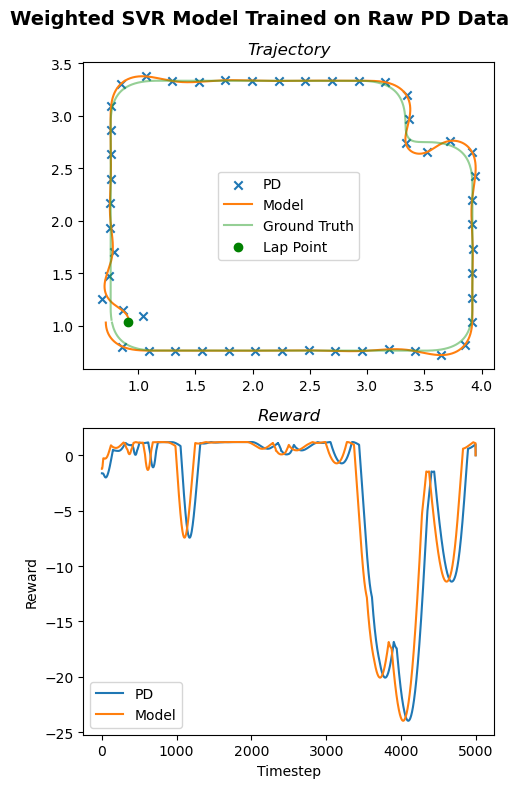

In [279]:
plot_traj_reward(x_pd, y_pd, x_model_first_lap, y_model_first_lap, x_gt_first_lap, y_gt_first_lap, df_model, df_pd, "Weighted SVR Model Trained on Raw PD Data")

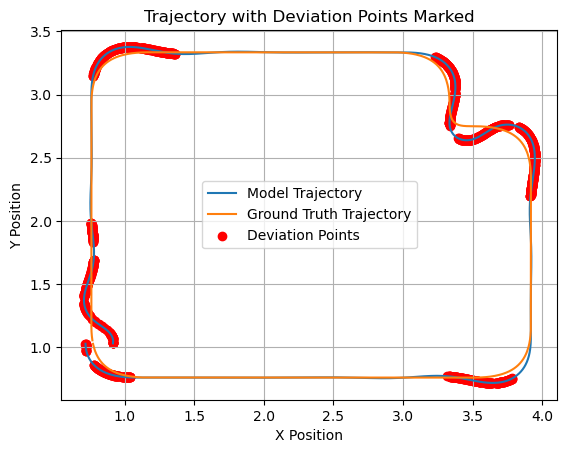

Time Spent Misaligned: 1540


In [282]:
plot_misalignment(x_model_first_lap, y_model_first_lap, x_gt_first_lap, y_gt_first_lap, max_angle_deviation=5)

In [171]:
# get first lap data
start_x = x_model[0]
start_y = y_model[0]

# tolerance
tol_x = 0.7
tol_y = 0.005

# find the second time x matches start_x 
lap_end_index = None
for i in range(4500, len(x_model)):
    if (abs(x_model[i] - start_x) <= tol_x) and (abs(y_model[i] - start_y) <= tol_y):
        lap_end_index = i
        break

# extract first lap data
if lap_end_index is not None:
    x_first_lap = x_model[:lap_end_index+1]
    y_first_lap = y_model[:lap_end_index+1]
else:
    x_first_lap = x_model
    y_first_lap = y_model

print(f"Timesteps for first lap: {len(x_first_lap)}")

Timesteps for first lap: 4856


Model Test Huber Loss: 0.04494061799599221
PD and Model Huber Loss: 0.012323747472710249
Ground Truth and Model Huber Loss: 0.012171703070228915


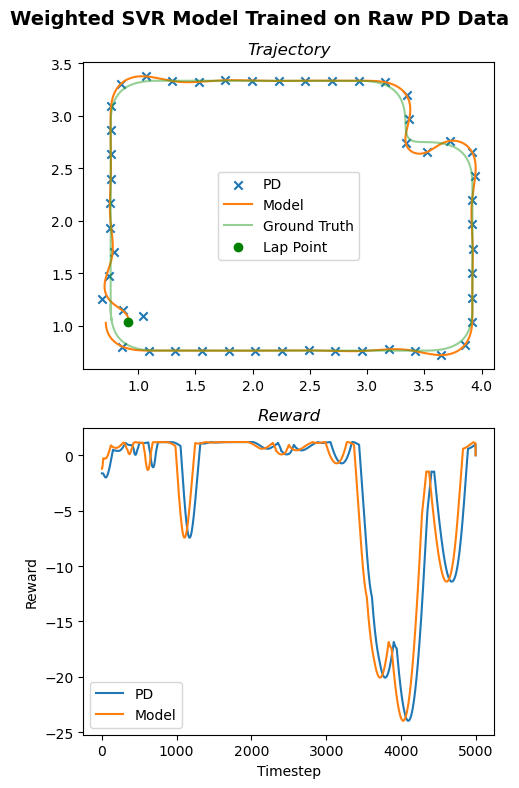

In [172]:
# plot and print data 

# create subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5,8))

fig.suptitle("Weighted SVR Model Trained on Raw PD Data", fontsize=14, fontweight='bold')

# plot trajectories for qualitative comparison
ax1.scatter(x_pd[:lap_end_index:100], y_pd[:lap_end_index:100], marker='x', label='PD', color='C0')
ax1.plot(x_model[:lap_end_index], y_model[:lap_end_index], label='Model', color='C1')
ax1.plot(x_gt, y_gt, label='Ground Truth', color='C2', alpha=0.5)
ax1.scatter([x_model[0]], [y_model[0]], color='green', label='Lap Point', zorder=5)
ax1.legend()
ax1.set_title("Trajectory", fontsize=12, fontstyle='italic')

# plot reward values for dnn and pd 
reward_model = df_model["reward"].values
reward_pd = df_pd["reward"].values

timestep_model = range(len(df_model))
timestep_pd = range(len(df_pd))

ax2.plot(timestep_pd, reward_pd, label='PD')
ax2.plot(timestep_model, reward_model, label='Model')
ax2.legend()
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Reward")
ax2.set_title("Reward", fontsize=12, fontstyle='italic')

plt.tight_layout()

print(f"Model Test Huber Loss: {model_test_hl}")
print(f"PD and Model Huber Loss: {pd_xy_model_test_hl}")
print(f"Ground Truth and Model Huber Loss: {gt_xy_model_test_hl}")

/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_15317/922910192.py:21: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


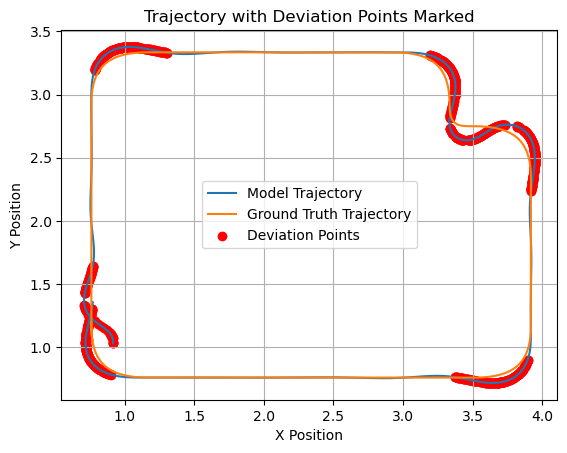

Time Spent Misaligned: 1231


In [173]:
# interpolate ground truth to match the length of model trajectory
f_x = interp1d(np.linspace(0, 1, len(x_gt)), x_gt, kind='linear')
f_y = interp1d(np.linspace(0, 1, len(y_gt)), y_gt, kind='linear')
x_gt = f_x(np.linspace(0, 1, len(x_model)))
y_gt = f_y(np.linspace(0, 1, len(y_model)))

# calculate direction vectors
def calculate_direction_vectors(x, y):
    dx = np.diff(x)
    dy = np.diff(y)
    return dx, dy

dx_model, dy_model = calculate_direction_vectors(x_model, y_model)
dx_gt, dy_gt = calculate_direction_vectors(x_gt, y_gt)

# calculate angles between direction vectors
def calculate_angles(dx1, dy1, dx2, dy2):
    dot_product = dx1 * dx2 + dy1 * dy2
    magnitude1 = np.sqrt(dx1**2 + dy1**2)
    magnitude2 = np.sqrt(dx2**2 + dy2**2)
    cosine_angle = dot_product / (magnitude1 * magnitude2)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))  # clip to handle numerical issues
    return np.degrees(angle)

angles = calculate_angles(dx_model, dy_model, dx_gt, dy_gt)

# set threshold
max_angle_deviation = 10 

# initialize variables
deviation_points = []

# find points where angle deviation exceeds threshold
for i in range(len(angles)):
    if angles[i] > max_angle_deviation:
        deviation_points.append((x_model[i+1], y_model[i+1]))  # i+1 because we used np.diff

# plot trajectory diagram with deviation points marked
plt.plot(x_model, y_model, label='Model Trajectory')
plt.plot(x_gt, y_gt, label='Ground Truth Trajectory')
deviation_points = np.array(deviation_points)
if deviation_points.size > 0:
    plt.scatter(deviation_points[:, 0], deviation_points[:, 1], color='red', label='Deviation Points')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Trajectory with Deviation Points Marked')
plt.legend()
plt.grid(True)
plt.show()

print(f"Time Spent Misaligned: {len(deviation_points)}")

## Processed Data - Unweighted

In [14]:
model_name = "unweighted_svr_model_processed_pd"

In [41]:
# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

min_length = min(len(x_pd), len(x_gt), len(x_model))

x_pd, y_pd = x_pd[:min_length], y_pd[:min_length]
x_gt, y_gt = x_gt[:min_length], y_gt[:min_length]
x_model, y_model = x_model[:min_length], y_model[:min_length]

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))

In [43]:
# evaluate model on test data
ypred = df_model['steering_angle'].values

ytrue = ytrue[0:len(ypred)]
ypred = ypred[0:len(ytrue)]

### Huber losses
- Testing loss
- PD coordinates loss
- Ground truth coordinates loss

In [44]:

model_test_hl = huber_loss(ypred, ytrue)

pd_xy_model_test_hl = huber_loss_coordinates(x_pd[0:len(x_model)], y_pd[0:len(y_model)], x_model, y_model)
gt_xy_model_test_hl = huber_loss_coordinates(x_gt[0:len(x_model)], y_gt[0:len(y_model)], x_model, y_model)


Model Test Huber Loss: 0.09992907828422254
PD and Model Huber Loss: 1.6524307104513971
Ground Truth and Model Huber Loss: 1.6426847788486332


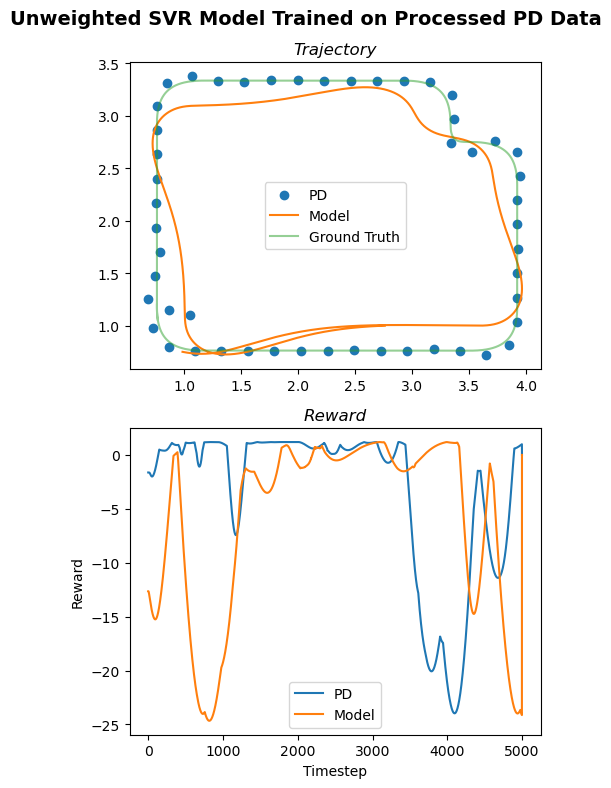

In [45]:
# plot and print data 

# create subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5,8))

fig.suptitle("Unweighted SVR Model Trained on Processed PD Data", fontsize=14, fontweight='bold')

# plot trajectories for qualitative comparison
ax1.scatter(x_pd[::100], y_pd[::100], label='PD', color='C0')
ax1.plot(x_model, y_model, label='Model', color='C1')
ax1.plot(x_gt, y_gt, label='Ground Truth', color='C2', alpha=0.5)
ax1.legend()
ax1.set_title("Trajectory", fontsize=12, fontstyle='italic')

# plot reward values for dnn and pd 
reward_model = df_model["reward"].values
reward_pd = df_pd["reward"].values

timestep_model = range(len(df_model))
timestep_pd = range(len(df_pd))

ax2.plot(timestep_pd, reward_pd, label='PD')
ax2.plot(timestep_model, reward_model, label='Model')
ax2.legend()
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Reward")
ax2.set_title("Reward", fontsize=12, fontstyle='italic')

plt.tight_layout()

print(f"Model Test Huber Loss: {model_test_hl}")
print(f"PD and Model Huber Loss: {pd_xy_model_test_hl}")
print(f"Ground Truth and Model Huber Loss: {gt_xy_model_test_hl}")

### Misalignment

c:\Users\sophi\anaconda3\envs\ad_project\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


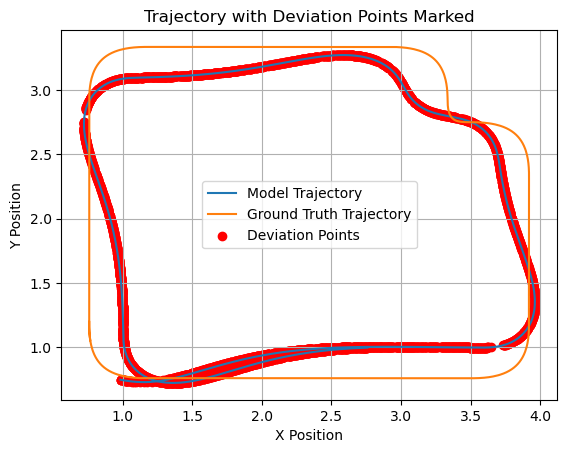

Time Spent Misaligned: 3986


In [46]:
# calculate direction vectors
def calculate_direction_vectors(x, y):
    dx = np.diff(x)
    dy = np.diff(y)
    return dx, dy

dx_model, dy_model = calculate_direction_vectors(x_model, y_model)
dx_gt, dy_gt = calculate_direction_vectors(x_gt, y_gt)

# calculate angles between direction vectors
def calculate_angles(dx1, dy1, dx2, dy2):
    dot_product = dx1 * dx2 + dy1 * dy2
    magnitude1 = np.sqrt(dx1**2 + dy1**2)
    magnitude2 = np.sqrt(dx2**2 + dy2**2)
    cosine_angle = dot_product / (magnitude1 * magnitude2)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))  # clip to handle numerical issues
    return np.degrees(angle)

angles = calculate_angles(dx_model, dy_model, dx_gt, dy_gt)

# set threshold
max_angle_deviation = 10 

# initialize variables
deviation_points = []

# find points where angle deviation exceeds threshold
for i in range(len(angles)):
    if angles[i] > max_angle_deviation:
        deviation_points.append((x_model[i+1], y_model[i+1]))  # i+1 because we used np.diff

# plot trajectory diagram with deviation points marked
plt.plot(x_model, y_model, label='Model Trajectory')
plt.plot(x_gt, y_gt, label='Ground Truth Trajectory')
deviation_points = np.array(deviation_points)
if deviation_points.size > 0:
    plt.scatter(deviation_points[:, 0], deviation_points[:, 1], color='red', label='Deviation Points')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Trajectory with Deviation Points Marked')
plt.legend()
plt.grid(True)
plt.show()

print(f"Time Spent Misaligned: {len(deviation_points)}")

## Processed Data - Weighted

In [31]:
model_name = "weighted_svr_model_processed_pd"

In [34]:
# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

min_length = min(len(x_pd), len(x_gt), len(x_model))

x_pd, y_pd = x_pd[:min_length], y_pd[:min_length]
x_gt, y_gt = x_gt[:min_length], y_gt[:min_length]
x_model, y_model = x_model[:min_length], y_model[:min_length]

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))

In [37]:
# evaluate model on test data
ypred = df_model['steering_angle'].values

ytrue = ytrue[0:len(ypred)]
ypred = ytrue[0:len(ytrue)]

### Huber losses
- Testing loss
- PD coordinates loss
- Ground truth coordinates loss

In [38]:

model_test_hl = huber_loss(ypred, ytrue)

pd_xy_model_test_hl = huber_loss_coordinates(x_pd[0:len(x_model)], y_pd[0:len(y_model)], x_model, y_model)
gt_xy_model_test_hl = huber_loss_coordinates(x_gt[0:len(x_model)], y_gt[0:len(y_model)], x_model, y_model)


Model Test Huber Loss: 0.0
PD and Model Huber Loss: 1.6524307104513971
Ground Truth and Model Huber Loss: 1.6426847788486332


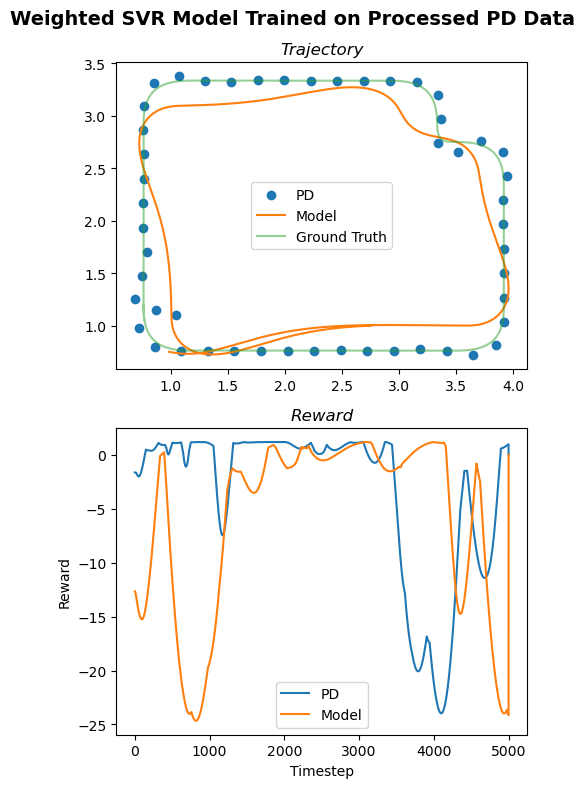

In [39]:
# plot and print data 

# create subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5,8))

fig.suptitle("Weighted SVR Model Trained on Processed PD Data", fontsize=14, fontweight='bold')

# plot trajectories for qualitative comparison
ax1.scatter(x_pd[::100], y_pd[::100], label='PD', color='C0')
ax1.plot(x_model, y_model, label='Model', color='C1')
ax1.plot(x_gt, y_gt, label='Ground Truth', color='C2', alpha=0.5)
ax1.legend()
ax1.set_title("Trajectory", fontsize=12, fontstyle='italic')

# plot reward values for dnn and pd 
reward_model = df_model["reward"].values
reward_pd = df_pd["reward"].values

timestep_model = range(len(df_model))
timestep_pd = range(len(df_pd))

ax2.plot(timestep_pd, reward_pd, label='PD')
ax2.plot(timestep_model, reward_model, label='Model')
ax2.legend()
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Reward")
ax2.set_title("Reward", fontsize=12, fontstyle='italic')

plt.tight_layout()

print(f"Model Test Huber Loss: {model_test_hl}")
print(f"PD and Model Huber Loss: {pd_xy_model_test_hl}")
print(f"Ground Truth and Model Huber Loss: {gt_xy_model_test_hl}")

### Misalignment

c:\Users\sophi\anaconda3\envs\ad_project\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


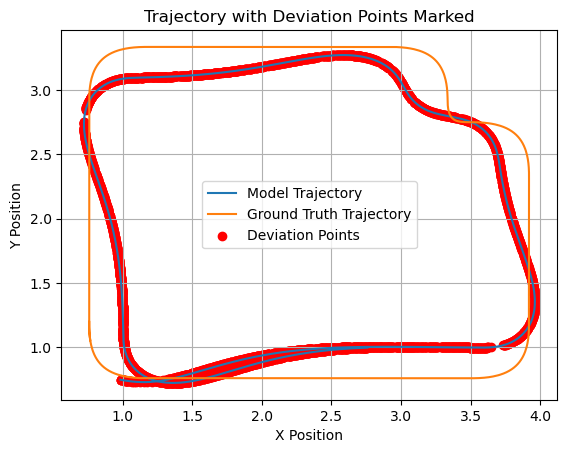

Time Spent Misaligned: 3986


In [40]:
# calculate direction vectors
def calculate_direction_vectors(x, y):
    dx = np.diff(x)
    dy = np.diff(y)
    return dx, dy

dx_model, dy_model = calculate_direction_vectors(x_model, y_model)
dx_gt, dy_gt = calculate_direction_vectors(x_gt, y_gt)

# calculate angles between direction vectors
def calculate_angles(dx1, dy1, dx2, dy2):
    dot_product = dx1 * dx2 + dy1 * dy2
    magnitude1 = np.sqrt(dx1**2 + dy1**2)
    magnitude2 = np.sqrt(dx2**2 + dy2**2)
    cosine_angle = dot_product / (magnitude1 * magnitude2)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))  # clip to handle numerical issues
    return np.degrees(angle)

angles = calculate_angles(dx_model, dy_model, dx_gt, dy_gt)

# set threshold
max_angle_deviation = 10 

# initialize variables
deviation_points = []

# find points where angle deviation exceeds threshold
for i in range(len(angles)):
    if angles[i] > max_angle_deviation:
        deviation_points.append((x_model[i+1], y_model[i+1]))  # i+1 because we used np.diff

# plot trajectory diagram with deviation points marked
plt.plot(x_model, y_model, label='Model Trajectory')
plt.plot(x_gt, y_gt, label='Ground Truth Trajectory')
deviation_points = np.array(deviation_points)
if deviation_points.size > 0:
    plt.scatter(deviation_points[:, 0], deviation_points[:, 1], color='red', label='Deviation Points')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Trajectory with Deviation Points Marked')
plt.legend()
plt.grid(True)
plt.show()

print(f"Time Spent Misaligned: {len(deviation_points)}")